In [1]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller 
from datetime import datetime
import requests
import pandas as pd
import numpy as np
import warnings
import json
warnings.filterwarnings("ignore")
mt5.initialize()
# Replace following with your MT5 Account Login
account=51434456 # 
password="9UpBvVzc"
server = 'ICMarkets-Demo'

def get_rates(pair1, timeframe, x):
    pair1 = pd.DataFrame(mt5.copy_rates_from_pos(pair1, timeframe, 0, x))
    pair1['time'] = pd.to_datetime(pair1['time'], unit = 's')
    return pair1[['time','open', 'high', 'low', 'close']].set_index('time')

## Data Gathering

In [2]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd

combined_dfs = {}

# Define the base URL for the BIS Stats API
base_url = 'https://stats.bis.org/api/v1'

count_codes = [['AUDUSD.a','AU'], ['USDCAD.a', 'CA'],
               ['USDCHF.a','CH'], ['GBPUSD.a', 'GB'],
               ['USDJPY.a', 'JP'], ['NZDUSD.a', 'NZ'], 
               ['EURUSD.a', 'XM']]

for country in count_codes:

    # Define the endpoint parameters
    flow = 'BIS,WS_EER_D,1.0'  # Example: Version 1.0 of the WS_EER_M domain, maintained by the BIS
    key = f'D.N.N.{country[1]}'
    start_period = '2000'  # Example: Start year 2000
    end_period = '2023'  # Example: End year 2020
    detail = 'full'  # Example: All data and documentation

    # Construct the endpoint URL
    endpoint_url = f'{base_url}/data/{flow}/{key}/all'

    # Define the query parameters
    query_params = {
        'startPeriod': start_period,
        'endPeriod': end_period,
        'detail': detail
    }

    # Make the GET request
    response = requests.get(endpoint_url, params=query_params)

    # Check for a successful response
    if response.status_code == 200:
        # Assign the text of the response to xml_data
        xml_data = response.text

        # Parse the XML data
        root = ET.fromstring(xml_data)

        # Initialize empty lists to store the data
        time_periods = []
        obs_values = []

        # Iterate through the XML and extract the desired information
        for obs in root.findall(".//Obs"):
            time_period = obs.get('TIME_PERIOD')
            obs_value = obs.get('OBS_VALUE')
            time_periods.append(time_period)
            obs_values.append(obs_value)

        # Create a DataFrame
        df = pd.DataFrame({
            'Time_Period': time_periods,
            'OBS_Value': obs_values
        })

        df['OBS_Value'] = df['OBS_Value'].replace('NaN', np.nan)
        # Drop rows with NaN values
        df.dropna(subset=['OBS_Value'], inplace=True)
        df['OBS_Value'] = df['OBS_Value'].astype(float)
        df['Time_Period'] = pd.to_datetime(df['Time_Period'])
        
        df = df.set_index('Time_Period')
        print(f"Getting {country[0]}'s rates")
        rates = get_rates(country[0], mt5.TIMEFRAME_D1, 2500)
        
        combined = pd.concat([df[-len(rates):], rates['close']], join = 'outer', axis = 1)
        
        combined_dfs[country[1]] = combined.dropna()

    else:
        print(f'Failed to retrieve data: {response.status_code}')

Getting AUDUSD.a's rates
Getting USDCAD.a's rates
Getting USDCHF.a's rates
Getting GBPUSD.a's rates
Getting USDJPY.a's rates
Getting NZDUSD.a's rates
Getting EURUSD.a's rates


In [259]:
# Compute Expected Returns
weekly_dfs = {}
features = ['OBS_Value', 'close']

for name, dfs in combined_dfs.items():
    df = combined_dfs[name]
    # Assuming 'df' is your DataFrame
    df['date'] = pd.to_datetime(df.index)
    df.set_index('date', inplace=True)

    # Resample to get the last value of each week
    weekly = df.resample('W').last()
    weekly_dfs[name] = weekly

for df in weekly_dfs.values():
    df['EER_ret'] = df['OBS_Value'].pct_change()
    df['close_ret'] = df['close'].pct_change()
    df['ret_diff'] = df['close_ret'] - df['EER_ret']

In [4]:
last_update = {}

for name, df in weekly_dfs.items():
    last_update[name] = df['EER_ret'].iloc[-1]

In [5]:
last_update.keys()
symbols = ['AUDUSD.a', 'USDCAD.a', 'USDCHF.a', 'GBPUSD.a', 'USDJPY.a', 'NZDUSD.a', 'EURUSD.a']

last_update = {symbols[i]: value for i, (key, value) in enumerate(last_update.items())}

## Order Sending / Closing Logic

In [870]:
def close_all():
    close_positions = []
    open_positions = mt5.positions_get()
    open_positions
    for i in open_positions:
        close_positions.append(i)
        
    for pos in close_positions:
        close_position(pos)
        
def close_position(position):

    tick = mt5.symbol_info_tick(position.symbol)

    request = {
        "action" : mt5.TRADE_ACTION_DEAL,
        "position": position.ticket,
        "symbol": position.symbol,
        "volume": position.volume,
        "type": mt5.ORDER_TYPE_BUY if position.type == 1 else mt5.ORDER_TYPE_SELL,
        "price": tick.ask if position.type == 1 else tick.bid,
        "deviation": 20,
        "magic": 100,
        "comment": 'Regres Close',
        'type_time': mt5.ORDER_TIME_GTC,
        'type_filling':mt5.ORDER_FILLING_IOC,

        }
    result = mt5.order_send(request)

In [26]:
close_all()

In [871]:
def send_order(symbol, side, lot, comment):
    
    if side.lower() == 'sell':
        order_type = mt5.ORDER_TYPE_SELL
        price = mt5.symbol_info_tick(symbol).bid
    elif side.lower() == 'buy':
        order_type = mt5.ORDER_TYPE_BUY
        price = mt5.symbol_info_tick(symbol).ask
    
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": lot,
        "type": order_type,
        "price": price,
        "deviation": 5,
        "magic": 234000,
        "comment": comment,
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_IOC,
    }
    result = mt5.order_send(request)
    result

# Risk Management

**High level approach**

ARIMA model to forecast return difference between EER_ret and close_ret (from week-1) to be used as a feature in a regression model along with the EER vals for week0.

Obtain an expected return (range?) to then create an MVO portfolio to run in a monte carlo simulation to obtain the most optimal weightings/allocation (optimised for sharpe ratio)

Steps
1. Create ARIMA and EER Val forecasts 
    - Run statistical analysis to incorporate differing variations 
2. Train a regression model on data to obtain expected returns
3. 

### Close / EER ret difference forecast (ARIMA Model)

Forecast next close ret / EER ret difference for each currency for the next week. If EER forecast is within the IQR ranges associated with each currency, adjust lot sizes accordingly

In [6]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

def evaluate_arima_model_aic_bic(series, arima_order):
    '''Evaluates ARIMA model for AIC and BIC'''
    try:
        model = ARIMA(series, order=arima_order)
        model_fit = model.fit()
        aic = model_fit.aic
        bic = model_fit.bic
        return aic, bic
    except Exception as e:
        print(f'Error with ARIMA order {arima_order}: {e}')
        return float('inf'), float('inf')

def find_best_arima_model(series, p_values, d_values, q_values):
    '''Find the best ARIMA model based on AIC and BIC'''
    best_aic, best_bic, best_cfg = float("inf"), float("inf"), None
    for p, d, q in itertools.product(p_values, d_values, q_values):
        order = (p, d, q)
        aic, bic = evaluate_arima_model_aic_bic(series, order)
        if aic < best_aic or bic < best_bic:
            best_aic, best_bic, best_cfg = aic, bic, order
            print(f'ARIMA{order} AIC: {aic}, BIC: {bic}')
    print(f'Best ARIMA{best_cfg} AIC: {best_aic}, BIC: {best_bic}')
    return best_cfg

In [150]:
best_arima_order

(0, 0, 1)

<AxesSubplot:xlabel='date'>

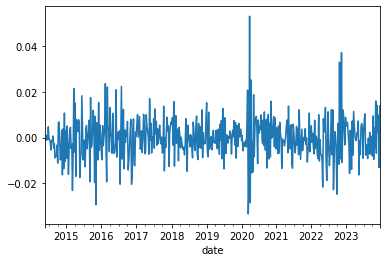

In [167]:
weekly_dfs['AU']['ret_diff'].plot()

In [185]:
arma_forecasts = {}
for df in weekly_dfs:
    print(f'Iterating through {df}')
    
    series = weekly_dfs[df]['ret_diff'] 

    best_arima_order = (2, 1, 2)

    best_model = ARIMA(series, order=best_arima_order)
    best_model_fit = best_model.fit()
    forecast = best_model_fit.forecast(steps=50)
    arma_forecasts[df] = forecast

Iterating through AU
Iterating through CA
Iterating through CH
Iterating through GB
Iterating through JP
Iterating through NZ
Iterating through XM


In [186]:
arma_forecasts

{'AU': 2023-12-24   -0.002946
 2023-12-31   -0.000999
 2024-01-07    0.001356
 2024-01-14   -0.001811
 2024-01-21    0.001102
 2024-01-28   -0.001307
 2024-02-04    0.000605
 2024-02-11   -0.000886
 2024-02-18    0.000268
 2024-02-25   -0.000622
 2024-03-03    0.000063
 2024-03-10   -0.000464
 2024-03-17   -0.000059
 2024-03-24   -0.000371
 2024-03-31   -0.000131
 2024-04-07   -0.000315
 2024-04-14   -0.000173
 2024-04-21   -0.000282
 2024-04-28   -0.000199
 2024-05-05   -0.000263
 2024-05-12   -0.000213
 2024-05-19   -0.000252
 2024-05-26   -0.000222
 2024-06-02   -0.000245
 2024-06-09   -0.000227
 2024-06-16   -0.000241
 2024-06-23   -0.000231
 2024-06-30   -0.000238
 2024-07-07   -0.000232
 2024-07-14   -0.000237
 2024-07-21   -0.000233
 2024-07-28   -0.000236
 2024-08-04   -0.000234
 2024-08-11   -0.000236
 2024-08-18   -0.000235
 2024-08-25   -0.000235
 2024-09-01   -0.000235
 2024-09-08   -0.000235
 2024-09-15   -0.000235
 2024-09-22   -0.000235
 2024-09-29   -0.000235
 2024-10-0

In [140]:
forecast_diff = {}

for key, val in last_update.items():
    for key2, val2 in arma_forecasts.items():
        if key2 in key:
            forecast_diff[key2] = (val - val2) / val
        else:
            if key == 'EURUSD.a':
                if key2 == 'XM':
                    forecast_diff[key2] = (val - val2) / val

In [141]:
forecast_diff

{'AU': 2023-12-24    1.044799
 Freq: W-SUN, dtype: float64,
 'CA': 2023-12-24    1.025587
 Freq: W-SUN, dtype: float64,
 'CH': 2023-12-24    0.638441
 Freq: W-SUN, dtype: float64,
 'GB': 2023-12-24    1.130399
 Freq: W-SUN, dtype: float64,
 'JP': 2023-12-24    1.036089
 Freq: W-SUN, dtype: float64,
 'NZ': 2023-12-24    0.859181
 Freq: W-SUN, dtype: float64,
 'XM': 2023-12-24    1.017419
 Freq: W-SUN, dtype: float64}

### Regression Model / Monte Carlo Sim / weights

In [187]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [272]:
models = {}

for df in weekly_dfs:
    print(f"Looping through {df}")

    X = weekly_dfs[df][['EER_ret']].dropna()
    y = weekly_dfs[df]['close_ret'].dropna()

    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    # Creating the linear regression model
    model = LinearRegression()
    models[df] = model
    # Training the model
    model.fit(X_train, y_train)

    # Making predictions using the testing set
    y_pred = model.predict(X_test)

    # The coefficients
    print('Coefficients:', model.coef_)
    # The mean squared error
    print('Mean squared error (MSE): %.6f' % mean_squared_error(y_test, y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination (R^2): %.6f' % r2_score(y_test, y_pred))

Looping through AU
Coefficients: [1.08553559]
Mean squared error (MSE): 0.000085
Coefficient of determination (R^2): 0.648780
Looping through CA
Coefficients: [-0.86214958]
Mean squared error (MSE): 0.000034
Coefficient of determination (R^2): 0.655828
Looping through CH
Coefficients: [-1.05147309]
Mean squared error (MSE): 0.000096
Coefficient of determination (R^2): 0.621076
Looping through GB
Coefficients: [0.98194026]
Mean squared error (MSE): 0.000090
Coefficient of determination (R^2): 0.446211
Looping through JP
Coefficients: [-0.91034833]
Mean squared error (MSE): 0.000055
Coefficient of determination (R^2): 0.527316
Looping through NZ
Coefficients: [1.26706108]
Mean squared error (MSE): 0.000113
Coefficient of determination (R^2): 0.470826
Looping through XM
Coefficients: [1.36449499]
Mean squared error (MSE): 0.000045
Coefficient of determination (R^2): 0.597834


In [331]:
def calc_stats(df):

    stats_df = pd.DataFrame()
    stats_df['mean'] = df.mean()
    stats_df['std'] = df.std()
    # print('calculated')
    return stats_df

In [332]:
calc_stats(weekly_dfs['AU'][['EER_ret']])

,mean,std
EER_ret,-0.000235,0.010647


In [508]:
stats = {}
for df in weekly_dfs:
    stats[df] = calc_stats(weekly_dfs[df][['EER_ret']])

In [595]:
all_returns = pd.DataFrame()
for sym in count_codes:
    # print(f'Iterating thru {sym}')
    rates = get_rates(sym[0], mt5.TIMEFRAME_D1, 2000)
    rates = rates['close']
    rates = rates.rename(f'{sym[0]}_close')
    all_returns = pd.concat([all_returns, rates], axis = 1)
latest_prices = all_returns.iloc[-1]

In [625]:
sims = 100

for i in range(sims):
    if (i + 1) % 100 == 0:
        print(f'{i + 1} simulations ran')

100 simulations ran


In [683]:
import numpy as np
from pypfopt import EfficientFrontier, risk_models, expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices 

num_simulations = 5000
all_weights = []

for i in range(num_simulations):

    if (i + 1) % 250 == 0:
        print(f'{i + 1} simulations ran')
    # Simulate the returns - this is a simple simulation; adjust as needed
    expected_return_lst = {}
    for df, values in stats.items():
        mean = values['mean']
        std = values['std']

        for df2, lr_model in models.items():
            if df == df2:
                # print(f'match found for {df} and {df2}')
                # Regression Model calculating expected returns 
                # expected_return_lst = {}
                random_eer_ret = np.random.normal(mean, std, 1).reshape(-1,1)
                # print(lr_model.predict(random_eer_ret))
                expected_return_lst[df2] = lr_model.predict(random_eer_ret)
            # Regression Model calculating expected returns 
            
    lst = []
    for i in expected_return_lst.values():
        lst.append(i)
        
    highest_return = max(lst)
    desired_scale = 0.05  # 5%
    scaling_factor = desired_scale / highest_return
    
    # Apply the scaling factor
    scaled_returns = [ret * scaling_factor for ret in lst] 
    scaled_values = [x[0] * 100 for x in scaled_returns]
    fin = []
    for i in scaled_values:
        fin.append(abs(i))
    
    # Calculate expected returns and the covariance matrix
    mu = fin
    S = risk_models.sample_cov(all_returns)

    # Optimize for the minimised volatility
    ef = EfficientFrontier(mu, S, weight_bounds = (0.05, 0.25))
    weights = ef.efficient_risk(0.025, market_neutral = False)
    cleaned_weights = ef.clean_weights()
    
    exp_ret, exp_vol, sharpe = ef.portfolio_performance()
    da = discrete_allocation.DiscreteAllocation(
    cleaned_weights, latest_prices, 
    total_portfolio_value = 10000, short_ratio = None)
    
    # Perform the discrete allocation
    allocation, leftover = da.lp_portfolio()
    # Calculate the total investment in each asset
    total_investment = {ticker: allocation[ticker] * latest_prices[ticker] for ticker in allocation}

    # Total value of the portfolio
    total_portfolio_value = sum(total_investment.values()) + leftover

    # Convert to percentages
    portfolio_percentages = {ticker: (value / total_portfolio_value) * 100 for ticker, value in total_investment.items()}
    
    # Store the weights from each simulation
    # all_weights[i, :] = np.array(list(portfolio_percentages.values()))
    all_weights.append([portfolio_percentages, exp_ret, exp_vol])

250 simulations ran
500 simulations ran
750 simulations ran
1000 simulations ran
1250 simulations ran
1500 simulations ran
1750 simulations ran
2000 simulations ran
2250 simulations ran
2500 simulations ran
2750 simulations ran
3000 simulations ran
3250 simulations ran
3500 simulations ran
3750 simulations ran
4000 simulations ran
4250 simulations ran
4500 simulations ran
4750 simulations ran
5000 simulations ran


In [684]:
weights_list = []
returns_list = []
volatility_list = []

# Extract values into separate lists
for item in all_weights:
    weights_list.append(item[0])  # Portfolio weights dictionary
    returns_list.append(item[1])  # Expected return
    volatility_list.append(item[2])  # Expected volatility

# Convert weights to DataFrame for easier mean calculation
df_weights = pd.DataFrame(weights_list)

# Calculate mean weights, returns, and volatility
mean_weights = df_weights.mean()
mean_return = np.mean(returns_list)
mean_volatility = np.mean(volatility_list)

print("Mean Portfolio Weights:")
print(mean_weights)
print("\nMean Expected Return:", mean_return)
print("Mean Expected Volatility:", mean_volatility)

Mean Portfolio Weights:
USDCAD.a_close    22.383952
USDCHF.a_close    20.492449
GBPUSD.a_close     8.815523
USDJPY.a_close    12.469194
NZDUSD.a_close    12.840159
EURUSD.a_close    13.983660
AUDUSD.a_close    11.752222
dtype: float64

Mean Expected Return: 8.205907365170354
Mean Expected Volatility: 0.024888403536426174


In [685]:
import pandas as pd
import numpy as np

weights_list = []
returns_list = []
volatility_list = []

# Extract values into separate lists
for item in all_weights:
    weights_list.append(item[0])  # Portfolio weights dictionary
    returns_list.append(item[1])  # Expected return
    volatility_list.append(item[2])  # Expected volatility

# Convert weights to DataFrame for easier mean and IQR calculation
df_weights = pd.DataFrame(weights_list)

# Calculate mean weights and IQR for each asset
mean_weights = df_weights.mean()
iqr_weights = df_weights.quantile(0.75) - df_weights.quantile(0.25)
iqr_25_weights = df_weights.quantile(0.25)
iqr_75_weights = df_weights.quantile(0.75)

# Combine return and volatility data
df_performance = pd.DataFrame({
    'expected_return': returns_list,
    'expected_volatility': volatility_list
})

# Calculate mean return and volatility
mean_return = df_performance['expected_return'].mean()
iqr_25_ret = df_performance['expected_return'].quantile(0.25)
iqr_75_ret = df_performance['expected_return'].quantile(0.75)

mean_volatility = df_performance['expected_volatility'].mean()
iqr_25_vol = df_performance['expected_volatility'].quantile(0.25)
iqr_75_vol = df_performance['expected_volatility'].quantile(0.75)

iqr_25_dict = {}
iqr_75_dict = {}
mean_dict = {}

for index, row in df_weights.iterrows():
    if row.isnull().any():
        row_sum = row.sum()
        shortfall = 100 - row_sum
        df_weights.at[index, row.isnull()] = shortfall

    # Convert weights to a tuple for hashability
    # tuple_weights = tuple(row.tolist())

In [686]:
iqr_25_dict['weights'] = iqr_25_weights
iqr_75_dict['weights'] = iqr_75_weights
mean_dict['weights'] = mean_weights

iqr_25_dict['ret'] = iqr_25_ret
iqr_75_dict['ret'] = iqr_75_ret
mean_dict['ret'] = mean_return

iqr_25_dict['vol'] = iqr_25_vol
iqr_75_dict['vol'] = iqr_75_vol
mean_dict['vol'] = mean_volatility

In [732]:
weights = {}
all_dicts = {}

all_dicts['iqr25'] = iqr_25_dict
all_dicts['iqr75'] = iqr_75_dict
all_dicts['mean_dict'] = mean_dict

for df, items in all_dicts.items():
    highest_ret = 0
    if all_dicts[df]['ret'] > highest_ret:
        highest_ret = all_dicts[df]['ret']
        weights = all_dicts[df]['weights']

In [716]:
def scale_weights(weights):

    total_weights = __builtins__.sum(weights.values)
    scaled = {currency: weight / total_weights * 100 for currency, weight in weights.items()}

    if isinstance(weights, pd.Series):
        return pd.Series(scaled)
    return scaled

In [757]:
weights = scale_weights(weights)

### scrap code

In [393]:
expected_return_lst = {}
for df, values in stats.items():
    mean = values['mean']
    std = values['std']
    
    for df2, lr_model in models.items():
        if df == df2:
            print(f'match found for {df} and {df2}')
            # Regression Model calculating expected returns 
            # expected_return_lst = {}
            random_eer_ret = np.random.normal(mean, std, 1).reshape(-1,1)
            print(lr_model.predict(random_eer_ret))
            expected_return_lst[df2] = lr_model.predict(random_eer_ret)
            

match found for AU and AU
[0.00976244]
match found for CA and CA
[-0.01374206]
match found for CH and CH
[0.00070739]
match found for GB and GB
[0.00295269]
match found for JP and JP
[-0.00557417]
match found for NZ and NZ
[-0.0166149]
match found for XM and XM
[0.00791541]


In [509]:
lst = []
for i in expected_return_lst.values():
    lst.append(i)

In [500]:
highest_return = max(lst)
desired_scale = 0.05  # 5%
scaling_factor = desired_scale / highest_return

In [501]:
# Apply the scaling factor
scaled_returns = [ret * scaling_factor for ret in lst] 
scaled_returns 

[array([0.05]),
 array([-0.07038234]),
 array([0.00362304]),
 array([0.01512269]),
 array([-0.02854906]),
 array([-0.08509608]),
 array([0.04054015])]

In [569]:
scaled_values = [x[0] * 100 for x in scaled_returns]

In [578]:
fin = []
for i in scaled_values:
    fin.append(abs(i))

In [585]:
from pypfopt import EfficientFrontier, risk_models, expected_returns

# Assuming 'data' is your DataFrame with historical returns
# Calculate expected returns and the covariance matrix
mu = fin
S = risk_models.sample_cov(all_returns)

# Optimize for the minimised volatility
ef = EfficientFrontier(mu, S, weight_bounds = (0.05, 0.25))
weights = ef.efficient_risk(0.025, market_neutral = False)
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

# Performance metrics
expected_return, expected_volatility, expected_sharpe = ef.portfolio_performance()

OrderedDict([('AUDUSD.a_close', 0.05), ('USDCAD.a_close', 0.25), ('USDCHF.a_close', 0.12749), ('GBPUSD.a_close', 0.05), ('USDJPY.a_close', 0.14772), ('NZDUSD.a_close', 0.2432), ('EURUSD.a_close', 0.13159)])


In [588]:
da = discrete_allocation.DiscreteAllocation(
    cleaned_weights, latest_prices, 
    total_portfolio_value = 10000, short_ratio = None)

In [591]:
# Perform the discrete allocation
allocation, leftover = da.lp_portfolio()
# Calculate the total investment in each asset
total_investment = {ticker: allocation[ticker] * latest_prices[ticker] for ticker in allocation}

# Total value of the portfolio
total_portfolio_value = sum(total_investment.values()) + leftover

# Convert to percentages
portfolio_percentages = {ticker: (value / total_portfolio_value) * 100 for ticker, value in total_investment.items()}

In [ ]:
import numpy as np

num_simulations = 1000
all_weights = np.zeros((num_simulations, len(data.columns)))

for i in range(num_simulations):
    # Simulate the returns - this is a simple simulation; adjust as needed
    simulated_returns = np.random.normal(mu, S, size=(len(data), len(data.columns)))
    
    # Re-run MVO for the simulated returns
    ef = EfficientFrontier(simulated_returns.mean(axis=0), risk_models.sample_cov(pd.DataFrame(simulated_returns)))
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    
    # Store the weights from each simulation
    all_weights[i, :] = np.array(list(cleaned_weights.values()))

# Orders 

### Simple Order Send
Copying EER return direction as data is released.

In [755]:
symbols = []
for sym in count_codes:
    symbols.append(sym[0])

In [756]:
all_pairs = list(combinations(symbols, 2))

In [ ]:
def adf_test(series1, series2):
    '''Runs ADF test on a spread series'''
    spread = series1 - series2
    result = adfuller(spread)
    return {'ADF Statistic': result[0], 'p-value': result[1], 'Critical Values': result[4]}

for sym in all_pairs:
    series1 = get_rates(sym[0], mt5.TIMEFRAME_D1, 500

In [64]:
def sim_send():
    for symbol, value in last_update.items():
        if symbol[:3] == 'USD':
            print(f"Looping through {symbol}")
            if value > 0:
                send_order(symbol, 'sell', 1.00, 'EER')
                print(f"Selling {symbol}")
            else:
                send_order(symbol, 'buy', 1.00, 'EER')
        else:
            if value > 0:
                send_order(symbol, 'buy', 1.00, 'EER')
            else:
                send_order(symbol, 'sell', 1.00, 'EER')

In [872]:
def mc_weights_send():
    for symbol, value in last_update.items():
        print(f"Looping through {symbol}")

        # Find the corresponding weight for the symbol
        for sym, weight in weights.items():
            if symbol[:7] == sym[:7]:  # Assuming symbol format like 'AUDUSD.a'
                lotsize = weight
                break
        else:
            continue  # If no matching weight is found, continue to next symbol

        # Determine whether to buy or sell based on the value
        lotsize = round(( weight / 7 ), 2)
        
        if value > 0:
            # If the value is positive, sell
            print(f"Selling {symbol}")
            send_order(symbol, 'buy', lotsize, 'EER_MC')
            
        else:
            # If the value is negative or zero, buy
            print(f"Bought {symbol}")
            send_order(symbol, 'sell', lotsize, 'EER_MC')

In [873]:
mc_weights_send()

Looping through AUDUSD.a
Selling AUDUSD.a
Looping through USDCAD.a
Selling USDCAD.a
Looping through USDCHF.a
Bought USDCHF.a
Looping through GBPUSD.a
Selling GBPUSD.a
Looping through USDJPY.a
Selling USDJPY.a
Looping through NZDUSD.a
Bought NZDUSD.a
Looping through EURUSD.a
Selling EURUSD.a


### Pair / Triplet Trading

Trading based on a cointegrating relationship within EER values

### Mean Reversion / Momentum 

Based on mean-reverting nature of EER values balanced with the momentum of EER values

# Research

Analyzing the relationship of EER data and close prices. 

In [737]:
for df in weekly_dfs.values():
    df['ret'] = df['close'].pct_change()
    df['ret_diff'] = df['EER_ret'] - df['ret']
    df = df.dropna()

In [738]:
for name, df in weekly_dfs.items():
    print(f"EER Correlation with {name} is: {df['EER_ret'].corr(df['ret'])}")

EER Correlation with AU is: 0.7895590513032674
EER Correlation with CA is: -0.8034449420507715
EER Correlation with CH is: -0.6962195656612519
EER Correlation with GB is: 0.6871875814155363
EER Correlation with JP is: -0.8164550108813893
EER Correlation with NZ is: 0.774779037008523
EER Correlation with XM is: 0.7549860097389316


In [739]:
desc_stats = pd.DataFrame()

for name in weekly_dfs:
    desc_stats[f"{name} Stats"] = weekly_dfs[name]['ret_diff'].describe()
desc_stats

,AU Stats,CA Stats,CH Stats,GB Stats,JP Stats,NZ Stats,XM Stats
count,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000
mean,0.000299,-0.000728,0.000471,0.000336,-0.001096,0.000350,0.000288
std,0.009047,0.018505,0.020930,0.009593,0.022437,0.009860,0.007556
min,-0.053037,-0.064334,-0.104875,-0.050289,-0.100707,-0.055615,-0.033891
25%,-0.005061,-0.011256,-0.009507,-0.005547,-0.013601,-0.005001,-0.004506
50%,0.000292,-0.000322,-0.000457,0.000599,-0.002314,0.000192,0.000589
75%,0.005601,0.011485,0.009052,0.005842,0.011016,0.005819,0.004759
max,0.033373,0.059054,0.284139,0.036804,0.077664,0.039223,0.029442


In [740]:
eer_vals = pd.DataFrame()

for name in weekly_dfs:
    eer_vals[f'{name}'] = weekly_dfs[name]['OBS_Value']

In [741]:
from statsmodels.tsa.stattools import coint
from itertools import combinations
import pandas as pd
from statsmodels.tsa.stattools import adfuller 

def cointegration_test(series1, series2):
    '''Runs cointegration test on two series'''
    score, p_value, _ = coint(series1, series2)
    return {'Cointegration Score': score, 'p-value': p_value}

In [742]:
all_pairs = list(combinations(eer_vals.columns, 2))
all_trips = list(combinations(eer_vals.columns, 3))

In [743]:
def adf_test(series1, series2):
    '''Runs ADF test on a spread series'''
    spread = series1 - series2
    result = adfuller(spread)
    return {'ADF Statistic': result[0], 'p-value': result[1], 'Critical Values': result[4]}

def johansen_test(data, det_order=0, k_ar_diff=1):

    result = coint_johansen(data, det_order, k_ar_diff)
    return result


In [744]:
# Perform cointegration test on each pair
coint_results = {}
for pair in all_pairs:
    series1, series2 = eer_vals[pair[0]], eer_vals[pair[1]]
    coint_test_result = adf_test(series1, series2)
    if coint_test_result['Critical Values']['10%'] > coint_test_result['ADF Statistic']:
        # print(f"{coint_test_result['Critical Values']['10%']} is smaller than {coint_test_result['ADF Statistic']}. Adding to results")
        coint_results[pair] = {'ADF_Stat': round(coint_test_result['ADF Statistic'], 4), 
                               '10%_stat': round(coint_test_result['Critical Values']['10%'], 4)}
coint_results

{('AU', 'NZ'): {'ADF_Stat': -4.1478, '10%_stat': -2.5699},
 ('CA', 'NZ'): {'ADF_Stat': -4.1739, '10%_stat': -2.5699},
 ('CA', 'XM'): {'ADF_Stat': -2.6991, '10%_stat': -2.5699},
 ('NZ', 'XM'): {'ADF_Stat': -2.571, '10%_stat': -2.5699}}

In [745]:
eer_vals

,AU,CA,CH,GB,JP,NZ,XM
date,,,,,,,
2014-05-25,119.55,118.63,90.36,114.02,95.19,113.35,105.64
2014-06-01,120.61,119.35,90.36,113.41,95.38,112.25,105.57
2014-06-08,121.06,118.37,90.58,113.84,94.61,112.78,105.71
2014-06-15,121.81,119.26,90.29,115.36,95.10,114.50,104.76
2014-06-22,121.76,119.58,90.48,115.60,94.96,114.89,105.11
...,...,...,...,...,...,...,...
2023-11-19,101.76,100.03,111.49,102.15,73.96,99.72,100.55
2023-11-26,102.54,100.19,111.62,102.95,73.69,100.72,100.65
2023-12-03,103.02,101.12,112.62,103.62,74.34,102.05,99.92


In [108]:
for sym in all_trips:
    data = eer_vals[sym[0]], eer_vals[sym[1]], eer_vals[sym[2]]
test_result = johansen_test(pd.DataFrame(data).T)
n = len(data)
for i in range(n):
    print(f"  At 90%: {test_result.trace_stat_crit_vals[i, 0]}, Trace Stat = {test_result.trace_stat[i]}")
    print(f"  At 95%: {test_result.trace_stat_crit_vals[i, 1]}, Trace Stat = {test_result.trace_stat[i]}")
    print(f"  At 99%: {test_result.trace_stat_crit_vals[i, 2]}, Trace Stat = {test_result.trace_stat[i]}")

  At 90%: 27.0669, Trace Stat = 26.334654627092632
  At 95%: 29.7961, Trace Stat = 26.334654627092632
  At 99%: 35.4628, Trace Stat = 26.334654627092632
  At 90%: 13.4294, Trace Stat = 7.676091331107257
  At 95%: 15.4943, Trace Stat = 7.676091331107257
  At 99%: 19.9349, Trace Stat = 7.676091331107257
  At 90%: 2.7055, Trace Stat = 0.7471535183749242
  At 95%: 3.8415, Trace Stat = 0.7471535183749242
  At 99%: 6.6349, Trace Stat = 0.7471535183749242


In [115]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
trip_coint_res = {}
for sym in all_trips:
    data = eer_vals[sym[0]], eer_vals[sym[1]], eer_vals[sym[2]]
    test_result = johansen_test(pd.DataFrame(data).T)
    
    if test_result.trace_stat_crit_vals[1,0] < test_result.trace_stat[1]:
        print(f"Result: {test_result.trace_stat_crit_vals[1,0]} < {test_result.trace_stat[1]}")
        print(f"{sym} cointegrates on a trip. level")
    
    # result = johansen_test(data)

Result: 13.4294 < 13.937368787819146
('AU', 'CA', 'GB') cointegrates on a trip. level
Result: 13.4294 < 19.290192302491445
('AU', 'CA', 'NZ') cointegrates on a trip. level
Result: 13.4294 < 17.71064339528753
('AU', 'CA', 'XM') cointegrates on a trip. level
Result: 13.4294 < 13.440846845315779
('AU', 'GB', 'XM') cointegrates on a trip. level
Result: 13.4294 < 18.203896258830596
('AU', 'NZ', 'XM') cointegrates on a trip. level
Result: 13.4294 < 15.570874597943478
('CA', 'CH', 'JP') cointegrates on a trip. level
Result: 13.4294 < 16.647381123213624
('CA', 'GB', 'NZ') cointegrates on a trip. level
Result: 13.4294 < 16.29832999361456
('CA', 'GB', 'XM') cointegrates on a trip. level
Result: 13.4294 < 23.233955281631843
('CA', 'NZ', 'XM') cointegrates on a trip. level
Result: 13.4294 < 14.135697301903793
('GB', 'NZ', 'XM') cointegrates on a trip. level


In [119]:
trip_coint_res = {}
for sym in all_trips:
    data = pd.DataFrame({sym[0]: eer_vals[sym[0]], sym[1]: eer_vals[sym[1]], sym[2]: eer_vals[sym[2]]})
    test_result = johansen_test(data)
    
    
    cointegrating_relations = sum(test_result.trace_stat > test_result.trace_stat_crit_vals[:, 1])
    if cointegrating_relations >= 3:
        trip_coint_res[sym] = cointegrating_relations

    # print(f"{sym} shows evidence of {cointegrating_relations} cointegrating relationship(s).")

# Output results
for trip, relations in trip_coint_res.items():
    print(f"{trip} has {relations} cointegrating relationship(s).")

('AU', 'CA', 'NZ') has 3 cointegrating relationship(s).
('AU', 'CA', 'XM') has 3 cointegrating relationship(s).
('AU', 'NZ', 'XM') has 3 cointegrating relationship(s).
('CA', 'GB', 'NZ') has 3 cointegrating relationship(s).
('CA', 'GB', 'XM') has 3 cointegrating relationship(s).
('CA', 'NZ', 'XM') has 3 cointegrating relationship(s).


In [124]:
eer_vals[['AU', 'CA', 'NZ']].describe()

,AU,CA,NZ
count,501.000000,501.000000,501.000000
mean,106.988363,104.074631,104.420279
std,5.515604,4.818668,4.175869
min,89.110000,93.230000,95.260000
25%,103.110000,101.220000,101.550000
50%,106.460000,102.940000,103.740000
75%,110.230000,105.950000,106.510000
max,124.420000,121.550000,116.580000


## Risk Management Framework

Aim is to take into account associated statistics between the two and minimise volatility whilst maximising return. Appropriate measures can include:
- MVO or BL Portfolio
- Correlation analysis and appropriate hedging associated 